## RAVDESS Dataset

### "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)
Female, as the actor ID number is even.

In [25]:
# load dataset from archive folder (Actor_01, Actor_02...), .wav file
import os
import pandas as pd

def load_dataset(archive_path):
    data = []
    for actor_folder in os.listdir(archive_path):
        actor_path = os.path.join(archive_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(actor_path, file_name)
                    # Extract data from file name
                    parts = file_name.split('-')
                    emotion_code = parts[2]
                    emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
                    emotion = emotion_map.get(emotion_code, 'unknown')
                    data.append({'file_path': file_path, 'emotion': emotion})
    df = pd.DataFrame(data)
    return df

In [26]:
# See dataset
df = load_dataset('archive')
print(df.head())
len(df)

                                   file_path  emotion
0  archive/Actor_11/03-01-02-02-02-01-11.wav     calm
1  archive/Actor_11/03-01-07-01-02-02-11.wav  disgust
2  archive/Actor_11/03-01-03-01-01-01-11.wav    happy
3  archive/Actor_11/03-01-06-01-01-01-11.wav  fearful
4  archive/Actor_11/03-01-03-02-02-02-11.wav    happy


1440

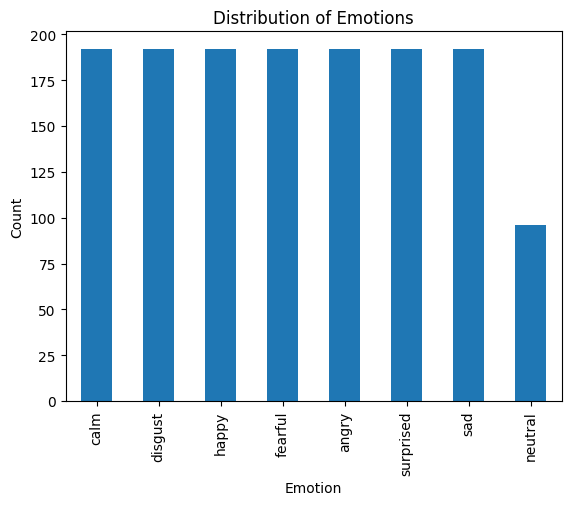

In [27]:
# Distribution of emotions graph
import matplotlib.pyplot as plt
emotion_counts = df['emotion'].value_counts()
emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.show()

In [28]:
import numpy as np
import librosa

SR = 16000  # Sample rate
DURATION = 3.0  # Duration in seconds
SAMPLES = int(SR * DURATION)  # Total samples per audio file

In [29]:
def load_audio(path, sr=SR, samples=SAMPLES):
    y, _ = librosa.load(path, sr=sr, mono=True)
    if len(y) > samples:
        y = y[:samples]
    else:
        y = np.pad(y, (0, max(0, samples - len(y))), "constant")
    return y

In [30]:
import numpy as np

N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 160
# With SR=16000, DURATION=3s, center=True -> 301 frames (usually)
TARGET_FRAMES = 301

def wav_to_logmel(path, sr=SR):
    y = load_audio(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    logmel = librosa.power_to_db(mel, ref=np.max)

    # Enforce fixed time frames
    frames = logmel.shape[1]
    if frames < TARGET_FRAMES:
        logmel = np.pad(logmel, ((0, 0), (0, TARGET_FRAMES - frames)), mode='constant')
    elif frames > TARGET_FRAMES:
        logmel = logmel[:, :TARGET_FRAMES]

    # per-sample normalization
    logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-6)

    return logmel.astype(np.float32)

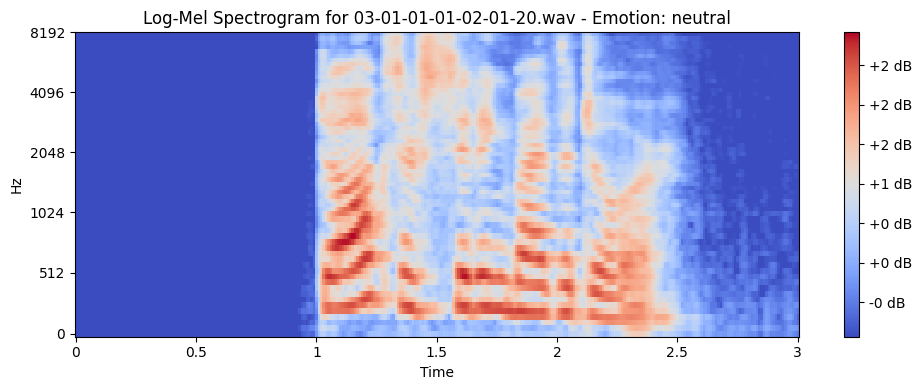

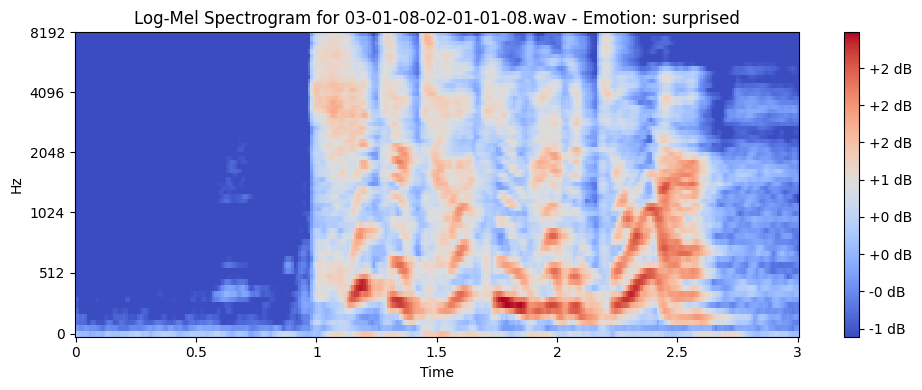

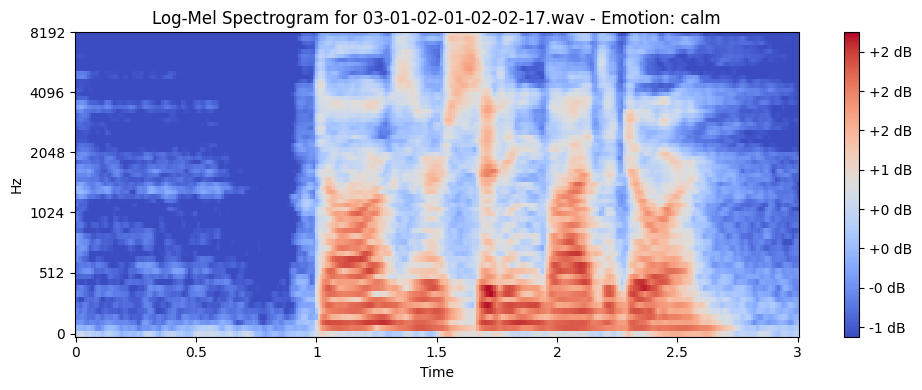

In [31]:
# Show three random log-mel spectrograms
import random
sample_files = random.sample(list(df['file_path']), 3)
for file in sample_files:
    logmel = wav_to_logmel(file)
    label = df[df['file_path'] == file]['emotion'].values[0]
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(logmel, sr=SR, hop_length=160, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram for {os.path.basename(file)} - Emotion: {label}')
    plt.tight_layout()
    plt.show()

In [32]:
import os

def parse_actor_id(file_path):
    base_name = os.path.basename(file_path)
    actor_id = int(base_name.split('-')[-1].split('.')[0])
    return actor_id

df = df[df['emotion'] != 'unknown'].copy()  # Filter out unknown emotions
df['actor_id'] = df['file_path'].apply(parse_actor_id)

df [["emotion", "actor_id"]].head(), df["emotion"].value_counts()

(   emotion  actor_id
 0     calm        11
 1  disgust        11
 2    happy        11
 3  fearful        11
 4    happy        11,
 emotion
 calm         192
 disgust      192
 happy        192
 fearful      192
 angry        192
 surprised    192
 sad          192
 neutral       96
 Name: count, dtype: int64)

In [33]:
import torch
import torch.nn as nn

EMOTIONS = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

class SpectrogramCNNV1(nn.Module):
    def __init__(self, num_classes=len(EMOTIONS), in_channels=1, dropout=0.2):
        super().__init__()

        def conv_block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(cout),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.features = nn.Sequential(
            conv_block(in_channels, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256)
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        x = self.classifier(x)
        return x

In [34]:
# quick shape check (uses your N_MELS and TARGET_FRAMES vars if defined)
model = SpectrogramCNNV1(num_classes=len(EMOTIONS))
dummy = torch.randn(4, 1, N_MELS, TARGET_FRAMES)
logits = model(dummy)
logits.shape

torch.Size([4, 8])

In [35]:
from torch.utils.data import Dataset, DataLoader

emotion_to_idx = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
idx_to_emotion = {idx: emotion for emotion, idx in emotion_to_idx.items()}

df = df[df['emotion'].isin(EMOTIONS)].copy()  # Ensure only known emotions are included

In [36]:
class RavdessSpectrogramDataset(Dataset):
    def __init__(self, df, emotion_to_idx, sr=SR):
        self.df = df.reset_index(drop=True)
        self.emotion_to_idx = emotion_to_idx
        self.sr = sr

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['file_path']
        emotion = row['emotion']
        logmel = wav_to_logmel(file_path, sr=self.sr)
        logmel = np.expand_dims(logmel, axis=0)  # Add channel dimension
        label = self.emotion_to_idx[emotion]
        return torch.tensor(logmel, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [37]:
# Split dataset into train and test based on actor IDs

rng = np.random.default_rng(42)
all_actors = df['actor_id'].unique()
rng.shuffle(all_actors)

test_actors = set(all_actors[:4])
train_actors = set(all_actors[4:])

train_df = df[df['actor_id'].isin(train_actors)].copy()
test_df = df[df['actor_id'].isin(test_actors)].copy()

len(train_df), len(test_df)

(1200, 240)

In [38]:
# Create datasets and dataloaders

BATCH_SIZE = 32

train_ds = RavdessSpectrogramDataset(train_df, emotion_to_idx)
test_ds = RavdessSpectrogramDataset(test_df, emotion_to_idx)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = SpectrogramCNNV1(num_classes=len(EMOTIONS)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def run_one_epoch_train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, optimizer, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total

cpu


In [ ]:
# Run train and test

EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch_train(model, train_dl, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_dl, optimizer, criterion, device)
    
    print(f'Epoch {epoch}/{EPOCHS} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {(train_acc*100):.2f}% - '
          f'Test Loss: {test_loss:.4f}, Test Acc: {(test_acc*100):.2f}%')

Epoch 1/10 - Train Loss: 1.8713, Train Acc: 28.0000% - Test Loss: 1.9778, Test Acc: 23.3333%
Epoch 2/10 - Train Loss: 1.6227, Train Acc: 39.9167% - Test Loss: 2.9780, Test Acc: 17.9167%
Epoch 3/10 - Train Loss: 1.5076, Train Acc: 45.0833% - Test Loss: 1.9196, Test Acc: 30.8333%
Epoch 4/10 - Train Loss: 1.3815, Train Acc: 49.4167% - Test Loss: 1.7784, Test Acc: 34.1667%
Epoch 5/10 - Train Loss: 1.2794, Train Acc: 53.0833% - Test Loss: 1.9007, Test Acc: 37.5000%
Epoch 6/10 - Train Loss: 1.2314, Train Acc: 54.5833% - Test Loss: 1.5057, Test Acc: 43.3333%
Epoch 7/10 - Train Loss: 1.1028, Train Acc: 61.7500% - Test Loss: 2.5858, Test Acc: 30.8333%
Epoch 8/10 - Train Loss: 1.0472, Train Acc: 63.4167% - Test Loss: 1.3138, Test Acc: 47.0833%
Epoch 9/10 - Train Loss: 1.0085, Train Acc: 66.0000% - Test Loss: 1.9770, Test Acc: 39.5833%
Epoch 10/10 - Train Loss: 0.9436, Train Acc: 66.5833% - Test Loss: 3.2028, Test Acc: 28.7500%
